In [1]:
import pandas as pd
import numpy as np
import os
import psycopg2
import pprint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# operations on dishes
dishes_all = pd.read_csv("backup-aug13/dishes.csv")
dishes_short_name = pd.read_csv("backup-aug13/dishes_short_name.csv")
dishes_merged = pd.merge(dishes_all, dishes_short_name, how = 'inner', left_on = 'food_id', right_on = 'id')[['id_x','food_id','short_name','name','avg_ratio']]
dishes_merged.rename(columns={'id_x': 'dish_id'}, inplace=True)

# separate dishes
dishes_chicken = dishes_merged[dishes_merged['short_name'] == 'A']
dishes_beef = dishes_merged[dishes_merged['short_name'] == 'B']
dishes_seafood = dishes_merged[dishes_merged['short_name'] == 'C']
dishes_veg = dishes_merged[(dishes_merged['short_name'] == 'D') | (dishes_merged['short_name'] == 'E') | (dishes_merged['short_name'] == 'F')]

# assign dishes
dishes = dishes_merged

# operations on success_metric
success_metric = pd.read_csv("backup-aug13/success_metric.csv")
success_metric.rename(columns={'id': 'food_id'}, inplace=True)

# other tables
answers = pd.read_csv("backup-aug13/answers.csv")
questions = pd.read_csv("backup-aug13/questions.csv")
users = pd.read_csv("backup-aug13/users.csv")


In [3]:
# group by occurence
answers['occurence'] = 1
grouped_answers = answers.groupby(['dish_id','question_id','value'])['occurence'].count().reset_index()

not_applicable = grouped_answers[(grouped_answers['value'] == 0) & (grouped_answers['occurence'] >= 3)]
applicable = grouped_answers[~((grouped_answers.dish_id.isin(not_applicable.dish_id.values)) & (grouped_answers.question_id.isin(not_applicable.question_id.values)))]

consensus = applicable[(applicable['occurence'] >= 4)]

# STILL TO CONSIDER: non_consensus = applicable[(applicable['occurence'] < 3)]
# For consensus (>=3) we are double counting, hence why used >= 3

In [4]:
def join_dishes_with_answers_for(df, q_num, dishes):
    question_df = df[(df['question_id'] == q_num)]
    question_df_join_dishes = pd.merge(question_df, dishes, how = 'inner', left_on = 'dish_id', right_on = 'dish_id')[['food_id','question_id','value','avg_ratio']]
    return question_df_join_dishes

q1_dishes = join_dishes_with_answers_for(consensus, 1, dishes)
q2_dishes = join_dishes_with_answers_for(consensus, 2, dishes)
q3_dishes = join_dishes_with_answers_for(consensus, 3, dishes)
q4_dishes = join_dishes_with_answers_for(consensus, 4, dishes)
q5_dishes = join_dishes_with_answers_for(consensus, 5, dishes)
q6_dishes = join_dishes_with_answers_for(consensus, 6, dishes)


In [5]:
def compute_decile(df):
    pdf = pd.DataFrame(df.avg_ratio)
    pdf['value'] = pd.DataFrame(df['value'].tolist())
    pdf['decile'] = pd.qcut(pdf['avg_ratio'], 10, labels=np.arange(10, 0, -1))
    return pdf


q1_deciles = compute_decile(q1_dishes)
q2_deciles = compute_decile(q2_dishes)
q3_deciles = compute_decile(q3_dishes)
q4_deciles = compute_decile(q4_dishes)
q5_deciles = compute_decile(q5_dishes)
q6_deciles = compute_decile(q6_dishes)


In [6]:
def prepare_data_for_plotting(df_deciles):

    x_decile = []
    y1_avg_ratio = []
    y2_percent_yes = []

    for decile in range(10):
        
        # add current decile to x-axis
        current_decile = decile + 1
        x_decile.append(current_decile)
        
        # calculate mean avg ratio for decile 
        avg_ratio = float(df_deciles[(df_deciles['decile'] == current_decile)][['avg_ratio']].mean())
        y1_avg_ratio.append(avg_ratio)
        
        # calculate percent yes for decile
        decile_count = float(df_deciles[(df_deciles['decile'] == current_decile)][['avg_ratio']].count())
        yes_count = float(df_deciles[(df_deciles['decile'] == current_decile) & (q1_deciles['value'] == 1)][['value']].count())
        percent_yes = float(yes_count/decile_count)
        y2_percent_yes.append(percent_yes)
        
    df = pd.DataFrame({"x_decile": x_decile, "y1_avg_ratio": y1_avg_ratio[::-1], "y2_percent_yes": y2_percent_yes[::-1]})
    return df

q1_prepped_data = prepare_data_for_plotting(q1_deciles)
q2_prepped_data = prepare_data_for_plotting(q2_deciles)
q3_prepped_data = prepare_data_for_plotting(q3_deciles)
q4_prepped_data = prepare_data_for_plotting(q4_deciles)
q5_prepped_data = prepare_data_for_plotting(q5_deciles)
q6_prepped_data = prepare_data_for_plotting(q6_deciles)

q6_deciles



avg_ratio  value decile
0     0.346801     -1      1
1     0.318598     -1      1
2     0.314354     -1      1
3     0.307729      1      1
4     0.307093     -1      1
5     0.303809     -1      1
6     0.303735     -1      1
7     0.302401      1      1
8     0.302186      1      1
9     0.300980     -1      1
10    0.300414     -1      1
11    0.300223     -1      1
12    0.300055     -1      1
13    0.298035     -1      1
14    0.296692     -1      1
15    0.296335     -1      1
16    0.296241      1      1
17    0.294956     -1      1
18    0.293146     -1      1
19    0.292326      1      1
20    0.288703      1      1
21    0.287884      1      1
22    0.287351      1      1
23    0.285546     -1      1
24    0.284722     -1      1
25    0.284605     -1      1
26    0.283847      1      1
27    0.283821     -1      1
28    0.283548      1      1
29    0.282632     -1      1
..         ...    ...    ...
387   0.047361      1     10
388   0.047313     -1     10
389   0.046977      1     10
390   0.046852     -1     10
391   0.046791     -1     10
392   0.046776     -1     10
393   0.046557     -1     10
394   0.046289      1     10
395   0.046172      1     10
396   0.045788      1     10
397   0.045189     -1     10
398   0.041526      1     10
399   0.040089     -1     10
400   0.038303      1     10
401   0.038068      1     10
402   0.038015     -1     10
403   0.037614     -1     10
404   0.037450      1     10
405   0.036623      1     10
406   0.036185      1     10
407   0.036049     -1     10
408   0.035351      1     10
409   0.034282      1     10
410   0.033630     -1     10
411   0.033560     -1     10
412   0.032704     -1     10
413   0.030622      1     10
414   0.029064      1     10
415   0.028975     -1     10
416   0.016960      1     10

[417 rows x 3 columns]

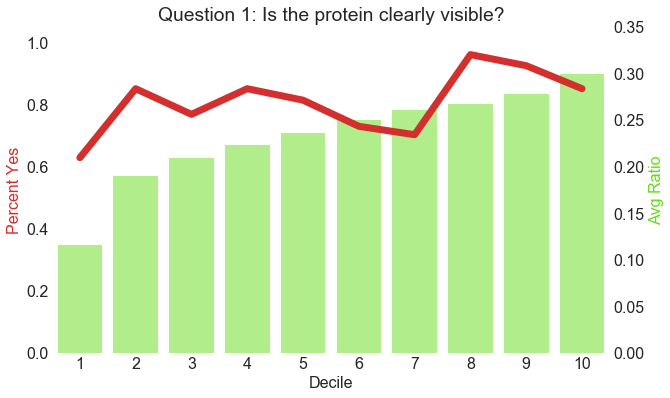

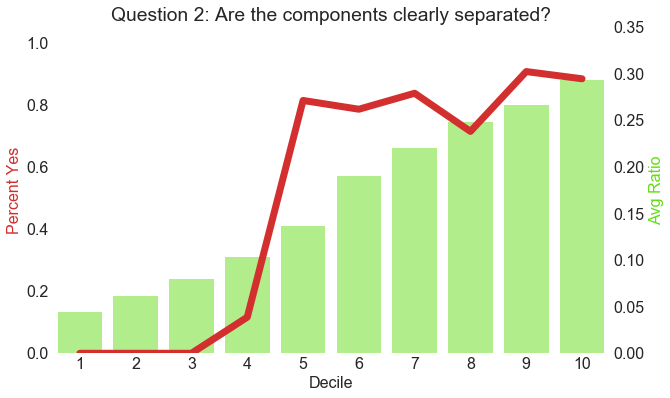

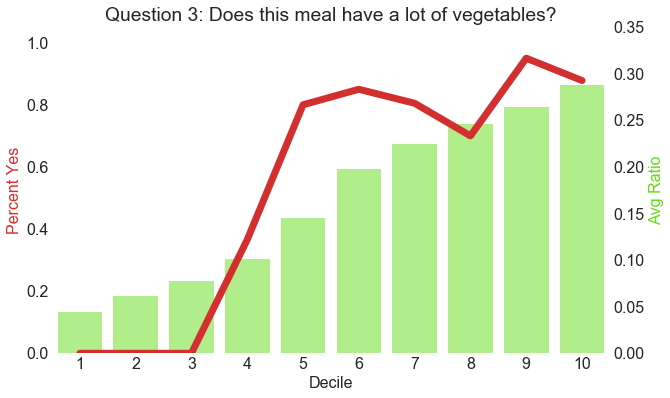

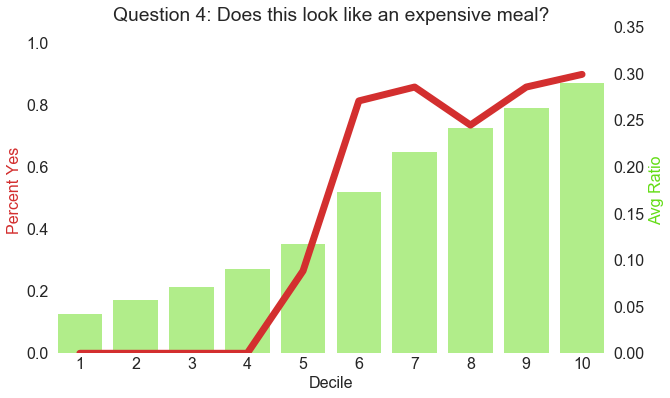

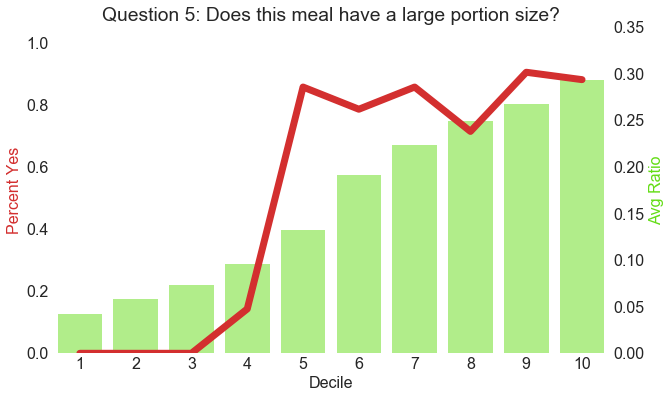

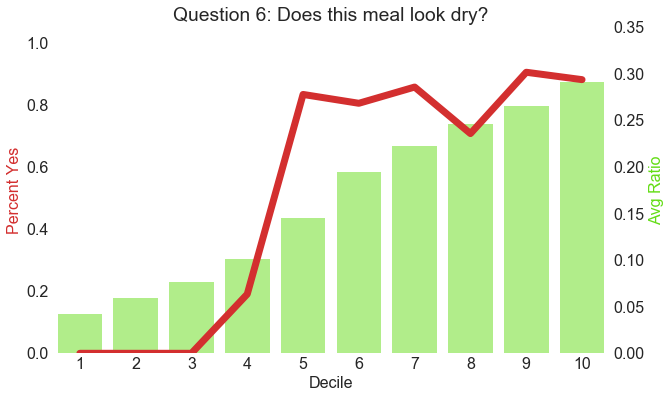

0.9443789764458707

In [9]:
def question_correlation_plot_for(df, title):
     
    x = df['x_decile'].tolist()
    percent_yes = df['y2_percent_yes'].tolist()
    avg_ratio = df['y1_avg_ratio'].tolist()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, percent_yes, color='#D32F2F',zorder=10, linewidth=7.0)
    ax2.bar(x, avg_ratio, color='#64DD17', alpha=0.5)

    ax1.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
    ax1.patch.set_visible(False) # hide the 'canvas' 

    ax1.set_xlabel('Decile')
    ax1.set_ylabel('Percent Yes', color='#D32F2F') 
    ax2.set_ylabel('Avg Ratio', color='#64DD17') 

    ax1.set_xlim(0.5,10.5)
    ax2.set_xlim(0.5,10.5)
    ax1.set_ylim(0,1.05)
    ax2.set_ylim(0,0.35)

    ax1.grid(False)
    ax2.grid(False)

    plt.title(title)    
    plt.xticks(x)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams.update({'font.size': 16})
    plt.show()


question_correlation_plot_for(q1_prepped_data, 'Question 1: Is the protein clearly visible?')
question_correlation_plot_for(q2_prepped_data, 'Question 2: Are the components clearly separated?')
question_correlation_plot_for(q3_prepped_data, 'Question 3: Does this meal have a lot of vegetables?')
question_correlation_plot_for(q4_prepped_data, 'Question 4: Does this look like an expensive meal?')
question_correlation_plot_for(q5_prepped_data, 'Question 5: Does this meal have a large portion size?')
question_correlation_plot_for(q6_prepped_data, 'Question 6: Does this meal look dry?')

q4_prepped_data['y2_percent_yes'].corr(q4_prepped_data['y1_avg_ratio'])